In [1]:
# Imports
import wikipedia
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import re
import requests
from bs4 import BeautifulSoup

In [2]:
# From https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_first_link(page_url):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")
    try:
        paragraphs = soup.find(id='mw-content-text').find(class_="mw-parser-output").find_all('p', recursive=False)
        link_list = []

        # Help links RegEx
        help_link_regex = re.compile('^/wiki/Help:')

        # Fails on languages for some reason but this works instead
        if "_language" in page_url:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]
            p1_links = filtered_paragaphs[0].find_all("a", recursive=False)
            
            try:
                first_link = p1_links[0].get('href')
                if first_link==None:
                    first_link = p1_links[1].get('href')
                return first_link
            except IndexError:
                original_name = page_url.lstrip("https://en.wikipedia.org/wiki/")
                return "!FAIL!: " + original_name
            
        for p in paragraphs:
            p_links = p.find_all("a", recursive=False)

            for link in p_links:
                # Leave them out if they match the previous RegEx
                if not help_link_regex.match(link.get('href')):
                    # print(link.get('href'))
                    link_list.append(link.get('href'))
                    break

        # Get the first link and return it
        try:
            first_link = link_list[0]
            return first_link
        except IndexError:
            original_name = page_url.lstrip("https://en.wikipedia.org/wiki/")
            return "!FAIL!: " + original_name
    except AttributeError:
        original_name = page_url.lstrip("https://en.wikipedia.org/wiki/")
        return "!FAIL!: " + original_name
    except TypeError:
        original_name = page_url.lstrip("https://en.wikipedia.org/wiki/")
        return "!FAIL!: " + original_name
            

In [3]:
def avg_dist_from_phil(G):
    distance_from_phil = []
    for node in G.nodes:
        try:
            shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
            distance_from_phil.append(shortest_path_length)

        except nx.NetworkXNoPath:
            continue

    return np.mean(distance_from_phil)

In [4]:
# Create Graph
G = nx.DiGraph()

# Add Philosophy as the first node
G.add_node("philosophy")

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
is_root = True

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
seen_pages = ["philosophy"]

# List of fails
fails = []

# Not connected to philosophy
disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
convergence_df = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree", "avg_dist_from_phil"])

In [5]:
# Function that finds a new random page on Wikipedia
def wiki_random_page(seen_pages):

    # Set up while loop that searches 
    already_seen_page = True

    while already_seen_page:

        # Use the wikipedia api to find a random page
        random_page = wikipedia.random()
        
        # If it has already seen the page, go back up and try again
        if random_page in seen_pages:
            already_seen_page = True
            continue

        # Ignoring pages that are just lists of other pages and disambiguation because they are not 'real' wikipedia pages used for understanding a topic
        elif "list of " in random_page.lower() or "list_of" in random_page.lower():
            already_seen_page = True
        
        elif '(disambiguation)' in random_page.lower():
            already_seen_page = True

        # If it is a new page, return the page and its url
        else:
            page_url = "https://en.wikipedia.org/wiki/" + random_page.replace(" ", "_")
            already_seen_page = False

    return random_page, page_url

In [6]:
# Testing the function
wiki_random_page(seen_pages)

('1907 Montenegrin parliamentary election',
 'https://en.wikipedia.org/wiki/1907_Montenegrin_parliamentary_election')

In [7]:
# # # Random seed for restarts
# # Starting page
# seed_page, first_page_url = wiki_random_page(G.nodes)
# seen_pages = G.nodes
# is_root = True

# # These start as the same thing
# root_page = seed_page

# # Create first url
# old_page = seed_page

In [9]:
def network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):
    old_between_cent = 0
    old_closeness_cent = 0
    old_avg_dist = 0

    notable_nodes = ["philosophy", "awareness", "knowledge", "science", "language"]

    root_page = page_url.lstrip("https://en.wikipedia.org/wiki/")
    
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="#336699", ncols=75):
        # Get the first link
        full_first_link = get_first_link(page_url=page_url)

        # If it fails, find try a new random page
        if "!FAIL!: " in full_first_link:
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append([seen_pages[-1], first_link])
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                
        elif "DEAD END: " in full_first_link:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, first_link)
        

        if i % 25 == 0 and all([True if node in G.nodes else False for node in notable_nodes]):

            new_between_cent = nx.betweenness_centrality(G, endpoints='philosophy')
            new_closeness_cent = nx.closeness_centrality(G)
            new_in_degree_cent = nx.in_degree_centrality(G)

            new_between_cent = {key: new_between_cent[key] for key in notable_nodes}
            new_closeness_cent = {key: new_closeness_cent[key] for key in notable_nodes}
            new_in_degree_cent = {key: new_in_degree_cent[key] for key in notable_nodes}

            new_avg_dist = avg_dist_from_phil(G)

            iteration = len(convergence_df.index) + i

            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node], new_avg_dist]
                convergence_df.loc[len(convergence_df.index)] = new_row


        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a self loop! Not connected to philosophy
        elif first_link == root_page:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link
            is_root = False

    return G, seen_pages, fails, disconnects, convergence_df


In [10]:
notable_nodes = ["philosophy", "awareness", "knowledge", "science", "language"]
[True if node in G.nodes else False for node in notable_nodes]

[True, False, False, False, False]

In [11]:
G.nodes

NodeView(('philosophy',))

In [12]:
G, seen_pages, fails, disconnects, convergence_df = network_expander(
    G,
    page_url=first_page_url,
    seen_pages=seen_pages,
    is_root=True,
    fails=fails,
    disconnects=disconnects,
    convergence_df=convergence_df,
    new_pages=5000,
)


Finding Paths: 100%|████████████████████████████████████████████| 5000/5000


In [14]:
convergence_df

,iteration,node,betweeness_centrality,closeness_centrality,in_degree,avg_dist_from_phil
0,50,philosophy,0.015957,0.103663,0.042553,7.189189
1,50,awareness,0.015514,0.079856,0.021277,7.189189
2,50,knowledge,0.022163,0.090780,0.042553,7.189189
3,50,science,0.020833,0.067749,0.042553,7.189189
4,50,language,0.039894,0.039280,0.021277,7.189189
...,...,...,...,...,...,...
985,5960,philosophy,0.000290,0.077951,0.002514,11.856949
986,5960,awareness,0.000256,0.043812,0.000629,11.856949
987,5960,knowledge,0.000312,0.040557,0.001886,11.856949
988,5960,science,0.000360,0.037029,0.003457,11.856949


In [13]:
first_link_path = './data/first-links.gml'
nx.write_gml(G, first_link_path)

convergence_df.to_csv("./data/convergence_data.csv")

In [3]:
first_link_path = './data/first-links.gml'
G = nx.read_gml(first_link_path)

convergence_df = pd.read_csv("./data/convergence_data.csv")

<AxesSubplot:xlabel='iteration', ylabel='closeness_centrality'>

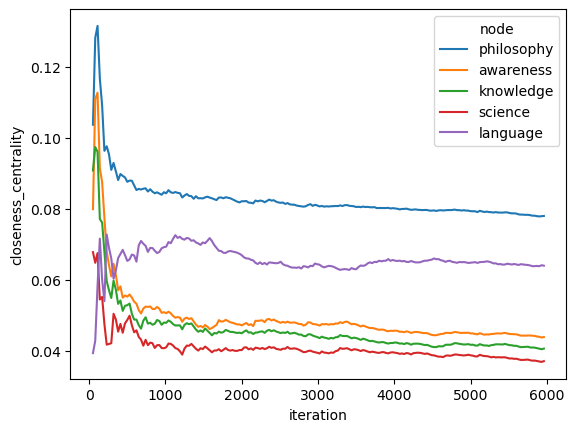

In [15]:
import seaborn as sns

sns.lineplot(convergence_df, x="iteration", y="closeness_centrality", hue="node")

<AxesSubplot:xlabel='iteration', ylabel='betweeness_centrality'>

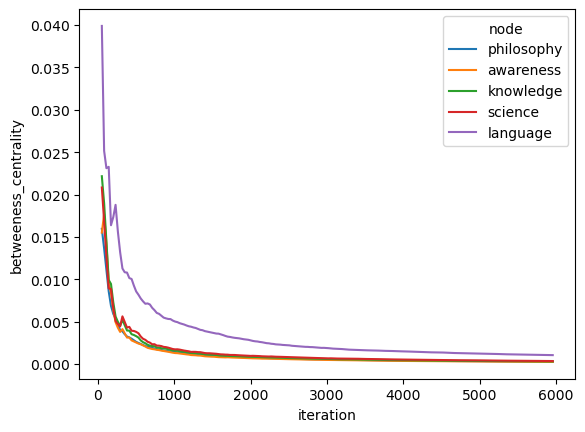

In [16]:
sns.lineplot(convergence_df, x="iteration", y="betweeness_centrality", hue="node")

In [17]:
def differences_to_previous(arr):
    if len(arr) < 2:
        return []  # Cannot calculate differences with less than two elements

    differences = [(arr[i] - arr[i - 1]) *100 for i in range(1, len(arr)-1)] 
    return differences

# Example usage:
result = differences_to_previous(np.array(convergence_df["in_degree"][convergence_df['node']=='language']))
print(result)

[0.8135168961201502, -0.6684491978609625, 0.4795663052543787, -0.4446012702893437, -0.3209373408048905, 0.9202217772986292, -0.30281007751938005, 0.21273474178403784, -0.24179411231336523, -0.1846690491253869, -0.16821602478972986, -0.1316298877274486, -0.1233792197406755, 0.17345966812051944, -0.12338171659219688, -0.10993411805353785, 0.15449872187420985, -0.08654702812778414, -0.10177234220950064, -0.07578349077704376, -0.062394891418265236, -0.06869125090383232, -0.06024096385542181, -0.062024158409700395, -0.04907444159780606, -0.04867249159216519, -0.04560382312050488, -0.04281649267510908, -0.03592024582918241, -0.03614041614626237, -0.038123711443634536, -0.030393909820319864, 0.12362565697396147, -0.031238001028250674, 0.11243143856336218, 0.10530267109214488, -0.03321256038647351, 0.0990602806166637, -0.03720526454493306, -0.03357759386912653, -0.032159409780243946, -0.030829215215124467, -0.02957987872249726, -0.033300911196182566, -0.03023062786892631, -0.02446071761630312,

In [18]:
convergence_df["avg_dist_from_phil"][convergence_df['node']=='philosophy']

0       7.189189
5       7.230769
10      7.431818
15      8.019231
20      8.177966
         ...    
965    11.835873
970    11.842014
975    11.864837
980    11.861481
985    11.856949
Name: avg_dist_from_phil, Length: 198, dtype: float64

<AxesSubplot:xlabel='iteration', ylabel='in_degree'>

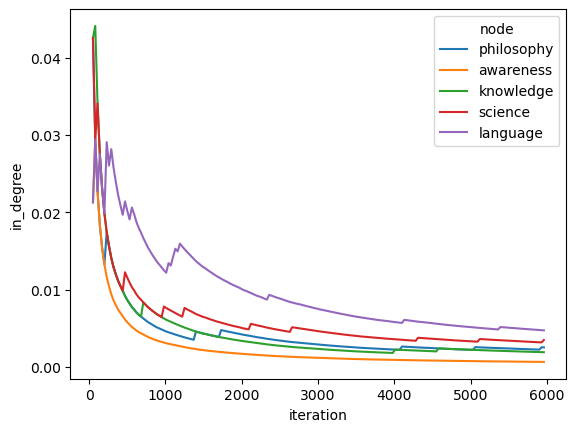

In [19]:
sns.lineplot(convergence_df, x="iteration", y="in_degree", hue="node")

<AxesSubplot:xlabel='iteration', ylabel='avg_dist_from_phil'>

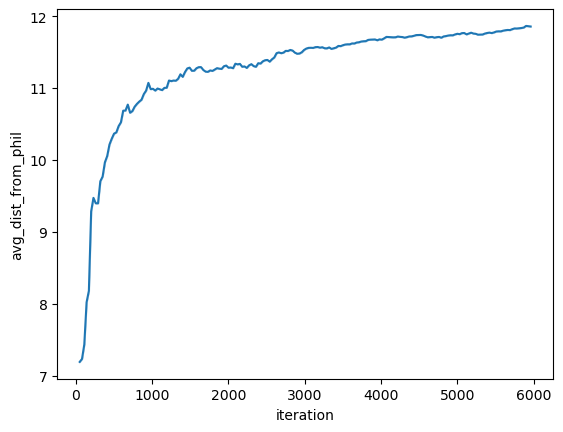

In [20]:
sns.lineplot(convergence_df, x="iteration", y="avg_dist_from_phil")

Look into core decompositions for displaying the network. Force directed would be better but is slow. 
Switch it to a directed graph.

In [27]:
# ------------------------------
# NETWORK PLOTTING FUNCTION
# ------------------------------
def plot_network(G, node_color="degree", layout="random"):
    # INITALIZE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    # NODE COLORS
    cmap = plt.cm.get_cmap("Greens")

    # DEGREE
    if node_color == "degree":
        centrality = list(dict(nx.degree(G)).values())

    # BETWENNESS
    if node_color == "betweeness":
        centrality = list(dict(nx.betweenness_centrality(G, endpoints="philosophy")).values())

    # CLOSENESS
    if node_color == "closeness":
        centrality = list(dict(nx.closeness_centrality(G)).values())

    # NODE SIZE CAN COLOR
    node_colors = [cmap(u / (0.01 + max(centrality))) for u in centrality]
    node_sizes = [10000 * u / (0.001 + max(centrality)) for u in centrality]

    scaled_node_sizes = [size if size > 3000 else 100 for size in node_sizes]

    scale = [size / max(node_sizes) for size in scaled_node_sizes]

    # POSITIONS LAYOUT
    N = len(G.nodes)
    if layout == "spring":
        # pos=nx.spring_layout(G,k=50*1./np.sqrt(N),iterations=100)
        pos = nx.spring_layout(G, scale=scale)

    if layout == "random":
        pos = nx.random_layout(G)

    if layout == "spiral":
        pos = nx.spiral_layout(G, scale=scale)

    if layout == "spectral":
        pos = nx.spectral_layout(G, scale=scale)
    
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)

    # PLOT NETWORK
    nx.draw(
        G,
        edgecolors="black",
        node_color=node_colors,
        node_size=scaled_node_sizes,
        pos=pos,
        with_labels=True
    )

    plt.show()


# G.remove_edges_from(nx.selfloop_edges(G))
# plot_network(nx.k_core(G, 50), node_color="degree", layout="spectral")


In [28]:
degree_dict = dict(G.in_degree())

# Create a dataframe with nodes and their degrees
df_nodes = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])

# Sort the dataframe by degree in descending order
df_nodes_sorted = df_nodes.sort_values(by='Degree', ascending=False)

df_nodes_sorted.head(10)

,Degree
french_language,32
sport,24
german_language,21
u.s._state,19
physics,17
public_university,16
family_(biology),16
biology,16
association_football,16
language,15


In [134]:
fails

[['!fail!: estelle_ricketts', '!fail!: estelle_ricketts'],
 ['!fail!: alegre_(surname)', '!fail!: alegre_(surname)'],
 ['!fail!: vietnamese_diasporic_music', '!fail!: vietnamese_diasporic_music'],
 ['!fail!: karen_briggs', '!fail!: karen_briggs'],
 ['!fail!: håkan_andersson', '!fail!: håkan_andersson'],
 ['shafi_uddin_shafi', 'shafi_uddin_shafi'],
 ['!fail!: temple_of_the_five_immortals',
  '!fail!: temple_of_the_five_immortals'],
 ['list_of_former_transcontinental_countries#since_1700',
  'list_of_former_transcontinental_countries#since_1700'],
 ['!fail!: cgh', '!fail!: cgh'],
 ['!fail!: william_dupree', '!fail!: william_dupree'],
 ['!fail!: tracey_ullman_show', '!fail!: tracey_ullman_show'],
 ['!fail!: fritz_gareis', '!fail!: fritz_gareis'],
 ['!fail!: echaurren', '!fail!: echaurren'],
 ['!fail!: latza', '!fail!: latza'],
 ['!fail!: god_and_gender', '!fail!: god_and_gender'],
 ['!fail!: 1894_in_bulgaria', '!fail!: 1894_in_bulgaria'],
 ['!fail!: class_87', '!fail!: class_87'],
 ['!fai

In [236]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # fails = fails[True if f[0]!=fail else False for f in fails]

    return G, seen_pages

In [242]:
G, seen_pages = fail_fixer(G, fail='!fail!: crime city', next_link="crime_film", seen_pages=seen_pages)

In [243]:
nx.shortest_path(G, "crime city","philosophy")

['crime city',
 'crime_film',
 'film_genre',
 'genre',
 'french_language',
 'romance_languages',
 'modern_language',
 'language',
 'communication',
 'information',
 'abstraction',
 'rule_of_inference',
 'philosophy_of_logic',
 'philosophy']

In [181]:
get_first_link("https://en.wikipedia.org/wiki/1604_in_France")

'!FAIL!: 1604_in_France'

In [133]:
disconnects

[]

In [29]:
# Calculate the degrees of each node
degrees = dict(G.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by degree:
french_language: 33
sport: 25
german_language: 22
u.s._state: 20
physics: 18
biology: 17
family_(biology): 17
association_football: 17
public_university: 17
language: 16


In [5]:
# Calculate the degrees of each node
in_degree = dict(nx.in_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by in_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by in_degree:
biology: 0.008990318118948825
sport: 0.00760719225449516
physics: 0.00760719225449516
ancient_greek_language: 0.006915629322268327
french_language: 0.006915629322268327
help:pronunciation_respelling_key: 0.006915629322268327
language: 0.006224066390041494
language_family: 0.006224066390041494
german_language: 0.005532503457814661
team_sport: 0.005532503457814661


In [30]:
# Calculate the degrees of each node
out_degree = dict(nx.out_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by out_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by out_degree:
private_university: 0.00031298904538341156
higher_education: 0.00031298904538341156
tertiary_education: 0.00031298904538341156
education: 0.00031298904538341156
knowledge: 0.00031298904538341156
awareness: 0.00031298904538341156
ologamasidae: 0.00031298904538341156
mesostigmata: 0.00031298904538341156
mite: 0.00031298904538341156
arachnid: 0.00031298904538341156


In [31]:
neighbors = [n[0] for n in list(G.in_edges("philosophy"))]
neighbor_degrees = [G.in_edges(n) for n in neighbors]
neighbors

['awareness',
 'philosophy_of_logic',
 'metaphysics',
 'aesthetics',
 'philosophical_tradition',
 'philosophy_of_culture',
 'philosopher_of_science',
 'post-structuralism',
 'american_enlightenment']

In [22]:
# Calculate the degrees of each node
betweeness_centrality = dict(nx.betweenness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by betweeness centrality:")
for node, betweeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {betweeness_centrality}")

Top nodes by betweeness centrality:
language: 0.0009048656371541711
communication: 0.0007594443023548653
information: 0.0006224503494913683
greek_language: 0.0005950123617933861
modern_greek: 0.000541900257035149
classical_language: 0.0004973135270259279
dialect: 0.000491237972607089
latin: 0.0004789888709562041
abstraction: 0.0004674257189977687
ancient_greek_language: 0.00037864423023215477


In [23]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by closeness centrality:")
for node, closeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {closeness_centrality}")

Top nodes by closeness centrality:
philosophy: 0.07799515336360505
language: 0.06396213345647656
communication: 0.057169937013126004
information: 0.05315005032062935
abstraction: 0.04813063294609507
rule_of_inference: 0.043938950906059974
awareness: 0.043633915044049155
philosophy_of_logic: 0.040424984350946484
knowledge: 0.0403916515854906
science: 0.0368787024455844


In [25]:
distance_from_phil = []
path_to_phil = []
nodes = []
for node in G.nodes:
    try:
        shortest_path = nx.shortest_path(G, node, "philosophy")
        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        nodes.append(node)
        distance_from_phil.append(shortest_path_length)
        path_to_phil.append(shortest_path)
    except nx.NetworkXNoPath:
        shortest_path = np.NAN
        shortest_path_length = np.NAN
        continue


# nodes  = [n for n in G.nodes]
df = pd.DataFrame(
    {"node": nodes, "distance": distance_from_phil, "shortest_path": path_to_phil}
)
print("AVERAGE DISTANCE TO PHILOSOPHY: ", np.mean(distance_from_phil))
df.sort_values("distance", inplace=True)
df.reset_index(inplace=True)
df.pop("index")
nodes = df["node"]
distances = df["distance"]
paths = df["shortest_path"]
print(
    "FURTHEST NODE: ",
    nodes[len(nodes) - 1],
    " is ",
    distances[len(distances) - 1],
    " pages away with a path of: ",
    paths[len(distances) - 1],
)
print(
    "THERE ARE "
    + str(
        sum([True if distance == max(distances) else False for distance in distances])
    )
    + " paths with a distance of "
    + str(max(distances))
)


AVERAGE DISTANCE TO PHILOSOPHY:  11.854194857916102
FURTHEST NODE:  john_gavin_(director)  is  24  pages away with a path of:  ['john_gavin_(director)', 'bushrangers', 'convicts_in_australia', 'penal_transportation', 'convict', 'guilt_(law)', 'criminal_law', 'law', 'law_enforcement', 'government', 'state_(polity)', 'politics', 'ancient_greek_language', 'greek_language', 'modern_greek', 'dialect', 'latin', 'classical_language', 'language', 'communication', 'information', 'abstraction', 'rule_of_inference', 'philosophy_of_logic', 'philosophy']
THERE ARE 2 paths with a distance of 24


In [32]:
ten_away = df[df['distance'] <= 5]

subgraph = G.subgraph(ten_away['node'])

plot_network(subgraph, node_color="closeness", layout="kamada_kawai")

In [138]:
plot_network(subgraph, node_color="betweeness", layout="kamada_kawai")

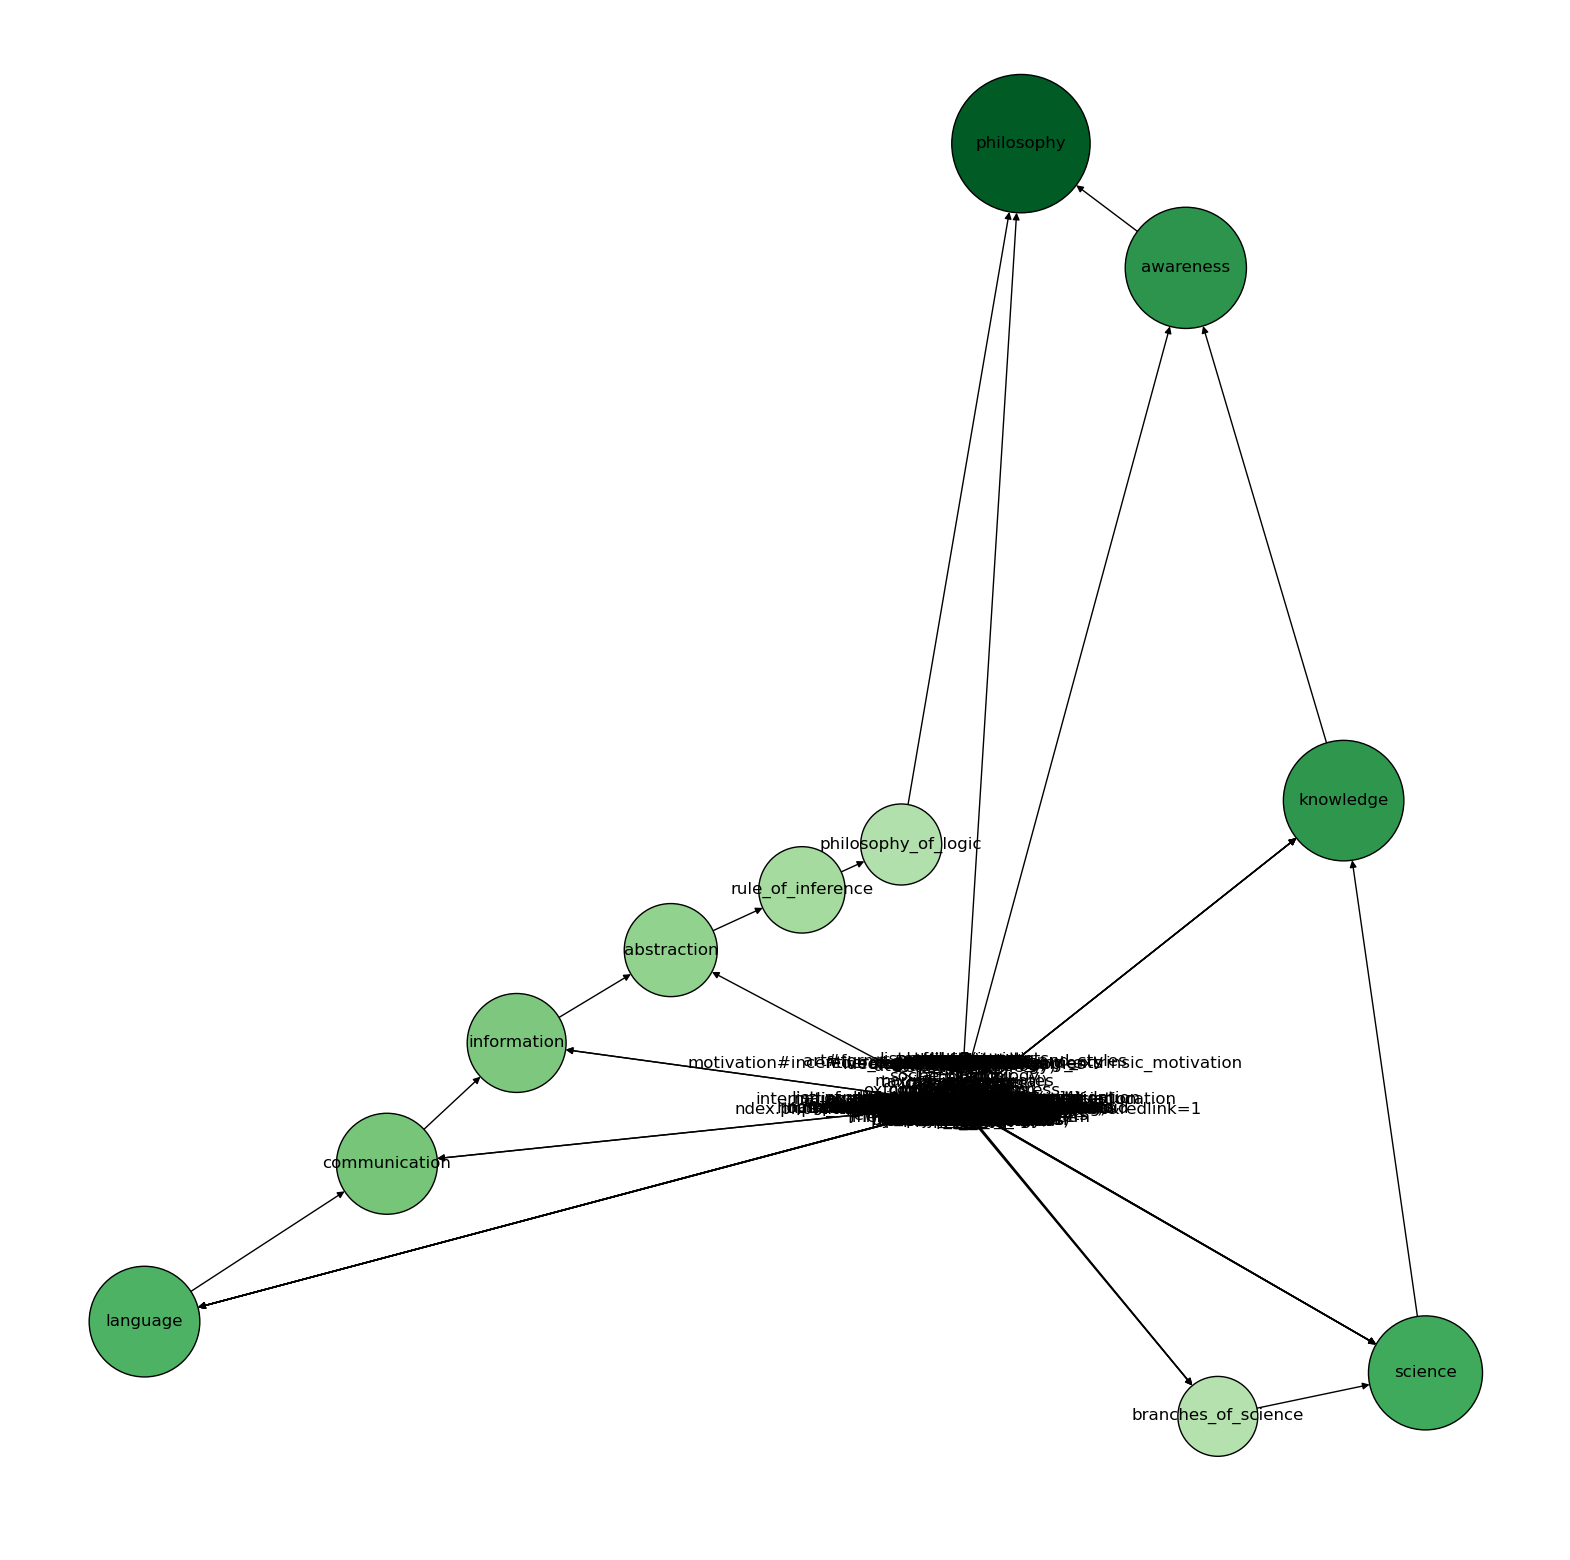

In [251]:
plot_network(subgraph, node_color="closeness", layout="spectral")

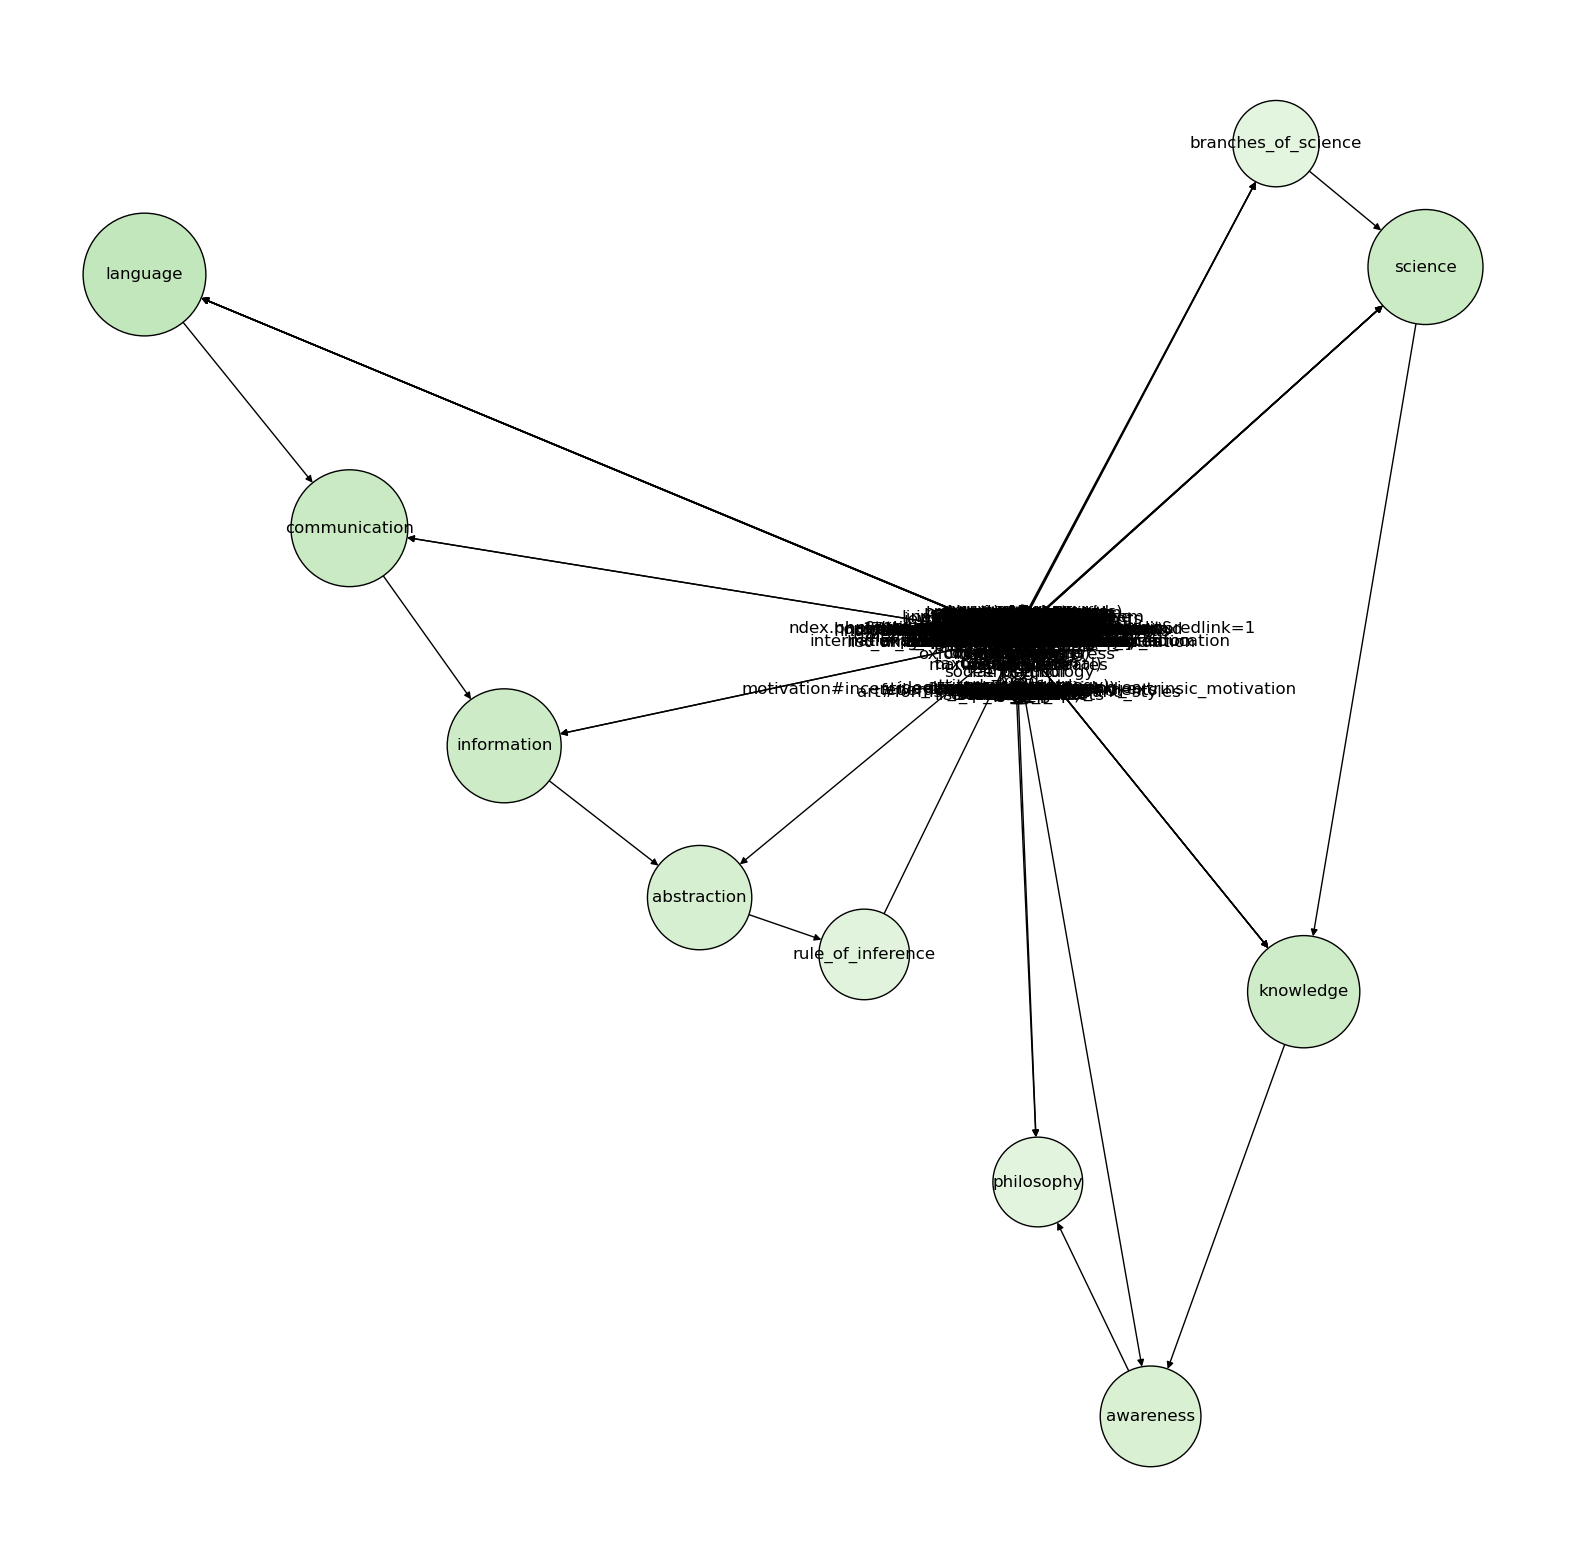

In [246]:
plot_network(subgraph, node_color="betweeness", layout="spectral")

In [188]:
path_appearances = []
for node in G.nodes:
    count = 0
    for path in paths:
        if node in path:
            count +=1
    
    path_appearances.append(count)

path_count_df = pd.DataFrame({"node":G.nodes, "appearances":path_appearances})
path_count_df = path_count_df.sort_values("appearances", ascending=False)
path_count_df.reset_index(inplace=True)
path_count_df.pop("index")

# Remove philosophy
path_count_df = path_count_df[1:]
path_count_df.head(80)

,node,appearances
1,philosophy_of_logic,717
2,rule_of_inference,716
3,abstraction,715
4,information,704
5,communication,681
...,...,...
76,environment_(systems),24
77,intellect,23
78,sociolinguistics,23
79,system,23


In [189]:
path_appearances = []
for path in np.unique(paths):
    count = sum([True if path==path_i else False for path_i in paths])
    path_appearances.append(count)

paths_df = pd.DataFrame({"path":np.unique(paths), "appearances":path_appearances})
paths_df = paths_df.sort_values("appearances", ascending=False)
paths_df.reset_index(inplace=True)
paths_df.pop("index")
paths_df

,path,appearances
0,"[!fail!: 1960 academy awards, acrobatics, anci...",1
1,"[physical_activity, exercise, human_body, huma...",1
2,"[paralympic_games, disability, cognitive_disab...",1
3,"[paraglider, adventure_sport, physical_activit...",1
4,"[papiamento_language, dutch_language, west_ger...",1
...,...,...
1287,"[environment_(systems), science, knowledge, aw...",1
1288,"[english_language, west_germanic_language, ger...",1
1289,"[english_land_law, real_property, english_comm...",1
1290,"[english_in_the_commonwealth_of_nations, engli...",1


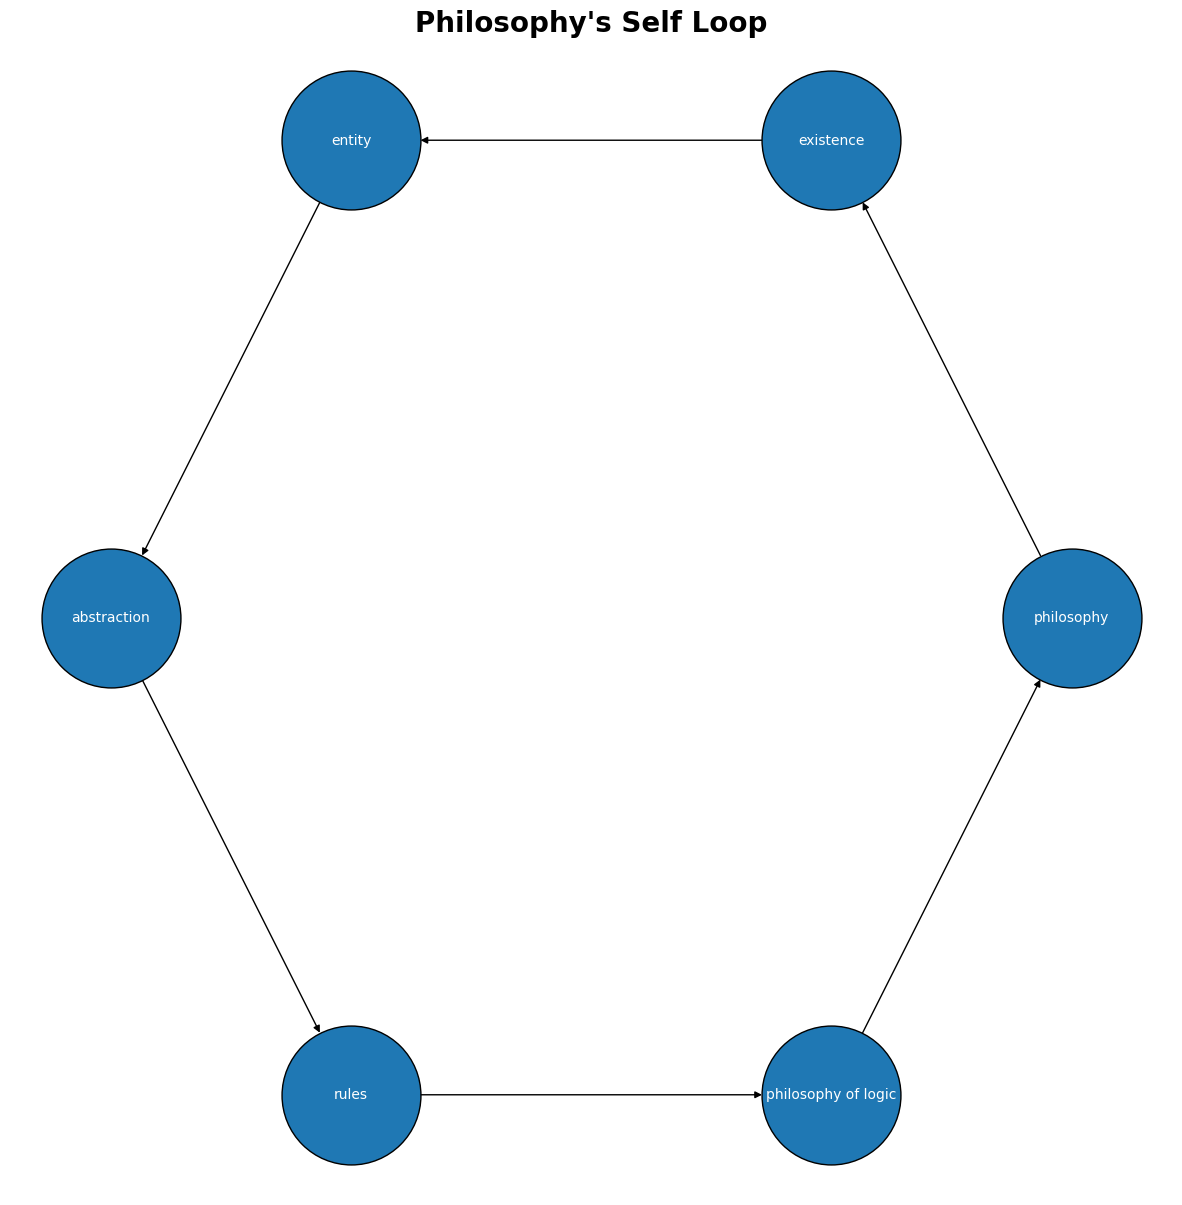

In [40]:
path = ['philosophy','existence', 'entity', 'abstraction', 'rules', 'philosophy of logic', 'philosophy']
G = nx.DiGraph()

for i, page_name in enumerate(path):
    G.add_node(page_name)
    if i == 0:
        pass
    else: 
        G.add_edge(old_page, page_name)
        old_page = page_name

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

pos = nx.circular_layout(G)
fig = nx.draw(G,
    with_labels=True,
    edgecolors="black",
    font_color="white",
    node_size=10000,
    pos=pos,
    font_size=10) 

plt.title("Philosophy's Self Loop", fontweight='bold', fontsize=20)
plt.savefig('../slides/Images/phil-loop.png')
plt.show()